# Fair-RecenzIA: Fairness Evaluation and Bias Mitigation

This notebook implements fairness metrics and bias mitigation techniques for the RecenzIA sentiment analysis system. We evaluate how machine learning models may exhibit biased behavior across demographic groups and apply mitigation strategies.

## Contents
1. Setup and Data Preparation
2. Baseline Fairness Evaluation
3. Bias Mitigation Techniques
   - Pre-processing: Fair Reweighting
   - Post-processing: Threshold Calibration
4. Results Comparison and Visualization

## 1. Setup and Imports

In [1]:
# Import required libraries
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add scripts directory to path
scripts_dir = Path('../scripts').resolve()
sys.path.insert(0, str(scripts_dir))

# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Fairness modules
from fairness_metrics import FairnessMetrics, compare_fairness_metrics
from bias_mitigation import (
    FairReweighting,
    ThresholdCalibrator,
    evaluate_mitigation
)

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("✓ All modules imported successfully")

✓ All modules imported successfully


## 2. Generate Synthetic Data with Demographics

Since the LaRoSeDa dataset doesn't include demographic metadata, we create a synthetic evaluation dataset with protected attributes (gender, age) while preserving sentiment class balance.

In [2]:
def generate_synthetic_dataset(n_samples=3000):
    """
    Generate synthetic sentiment dataset with demographic attributes.
    
    This simulates:
    - Text reviews (represented as numerical features)
    - Sentiment labels (binary: 0=negative, 1=positive)
    - Gender (Male=1, Female=0)
    - Age groups (Young, Middle, Senior)
    """
    np.random.seed(RANDOM_SEED)
    
    # Generate features (simulating text embeddings)
    n_features = 20
    X = np.random.randn(n_samples, n_features)
    
    # Generate true sentiment labels (60% positive)
    y_true = np.random.binomial(1, 0.6, n_samples)
    
    # Generate demographic attributes
    # Gender: Male (52%), Female (48%)
    gender = np.random.choice(['Male', 'Female'], size=n_samples, p=[0.52, 0.48])
    
    # Age groups: Young (40%), Middle (35%), Senior (25%)
    age_group = np.random.choice(
        ['Young_18-35', 'Middle_36-55', 'Senior_56+'],
        size=n_samples,
        p=[0.40, 0.35, 0.25]
    )
    
    # Binary protected attribute: Female=0 (unprivileged), Male=1 (privileged)
    protected_attr = (gender == 'Male').astype(int)
    
    # Create DataFrame
    df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(n_features)])
    df['label'] = y_true
    df['gender'] = gender
    df['age_group'] = age_group
    df['protected_attr'] = protected_attr
    
    return df

# Generate dataset
df_full = generate_synthetic_dataset(n_samples=3000)

# Display statistics
print("Dataset Statistics:")
print(f"Total samples: {len(df_full)}")
print(f"\nSentiment distribution:")
print(df_full['label'].value_counts())
print(f"\nGender distribution:")
print(df_full['gender'].value_counts())
print(f"\nAge group distribution:")
print(df_full['age_group'].value_counts())

# Show first few rows
df_full.head()

Dataset Statistics:
Total samples: 3000

Sentiment distribution:
label
1    1781
0    1219
Name: count, dtype: int64

Gender distribution:
gender
Male      1538
Female    1462
Name: count, dtype: int64

Age group distribution:
age_group
Young_18-35     1182
Middle_36-55    1055
Senior_56+       763
Name: count, dtype: int64


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,label,gender,age_group,protected_attr
0,0.496714,-0.138264,0.647689,1.523030,-0.234153,-0.234137,1.579213,0.767435,-0.469474,0.542560,...,-1.724918,-0.562288,-1.012831,0.314247,-0.908024,-1.412304,1,Female,Young_18-35,0
1,1.465649,-0.225776,0.067528,-1.424748,-0.544383,0.110923,-1.150994,0.375698,-0.600639,-0.291694,...,0.822545,-1.220844,0.208864,-1.959670,-1.328186,0.196861,0,Male,Young_18-35,1
2,0.738467,0.171368,-0.115648,-0.301104,-1.478522,-0.719844,-0.460639,1.057122,0.343618,-1.763040,...,1.031000,0.931280,-0.839218,-0.309212,0.331263,0.975545,0,Female,Senior_56+,0
3,-0.479174,-0.185659,-1.106335,-1.196207,0.812526,1.356240,-0.072010,1.003533,0.361636,-0.645120,...,-2.619745,0.821903,0.087047,-0.299007,0.091761,-1.987569,1,Male,Young_18-35,1
4,-0.219672,0.357113,1.477894,-0.518270,-0.808494,-0.501757,0.915402,0.328751,-0.529760,0.513267,...,-0.392108,-1.463515,0.296120,0.261055,0.005113,-0.234587,1,Male,Senior_56+,1


## 3. Train a Baseline Model (with Induced Bias)

We'll train a logistic regression model and introduce bias by simulating lower accuracy for the unprivileged group (Female).

In [3]:
# Split data
feature_cols = [col for col in df_full.columns if col.startswith('feature_')]
X = df_full[feature_cols].values
y = df_full['label'].values
protected_attr = df_full['protected_attr'].values

X_train, X_test, y_train, y_test, protected_train, protected_test = train_test_split(
    X, y, protected_attr, test_size=0.3, random_state=RANDOM_SEED, stratify=y
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

# Train baseline model
baseline_model = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED)
baseline_model.fit(X_train, y_train)

# Get predictions
y_pred_baseline = baseline_model.predict(X_test)
y_score_baseline = baseline_model.predict_proba(X_test)[:, 1]

# Introduce bias: Add more errors for unprivileged group (Female=0)
# This simulates a model that performs worse on female-authored reviews
y_pred_biased = y_pred_baseline.copy()
unprivileged_mask = protected_test == 0

# Add false negatives for unprivileged group
unprivileged_positive_indices = np.where(unprivileged_mask & (y_test == 1) & (y_pred_baseline == 1))[0]
if len(unprivileged_positive_indices) > 0:
    # Flip 15% of correct positive predictions to wrong for unprivileged group
    n_flip = int(0.15 * len(unprivileged_positive_indices))
    flip_indices = np.random.choice(unprivileged_positive_indices, size=n_flip, replace=False)
    y_pred_biased[flip_indices] = 0

# Performance metrics
print("\n" + "="*70)
print("BASELINE MODEL PERFORMANCE")
print("="*70)
print(f"Accuracy: {accuracy_score(y_test, y_pred_biased):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_biased):.4f}")
print("\n" + classification_report(y_test, y_pred_biased))

Training set: 2100 samples
Test set: 900 samples

BASELINE MODEL PERFORMANCE
Accuracy: 0.5522
F1-Score: 0.7078

              precision    recall  f1-score   support

           0       0.16      0.02      0.04       366
           1       0.58      0.91      0.71       534

    accuracy                           0.55       900
   macro avg       0.37      0.47      0.38       900
weighted avg       0.41      0.55      0.44       900



## 4. Baseline Fairness Evaluation

Now let's compute fairness metrics to quantify bias in the baseline model.

In [4]:
# Compute fairness metrics
fm_baseline = FairnessMetrics(y_test, y_pred_biased, protected_test)

# Print comprehensive report
print(fm_baseline.fairness_report())

# Get metrics dictionary
baseline_fairness = fm_baseline.compute_all_metrics()
print("\nFairness Metrics Summary:")
for metric, value in baseline_fairness.items():
    print(f"  {metric.upper()}: {value:+.4f}")

FAIRNESS EVALUATION REPORT

GROUP STATISTICS
----------------------------------------------------------------------

UNPRIVILEGED GROUP (n=437):
  True Positive Rate (TPR):  0.8462
  False Positive Rate (FPR): 0.9774
  Positive Prediction Rate:  0.8993
  Confusion Matrix: TP=220, FP=173, TN=4, FN=40

PRIVILEGED GROUP (n=463):
  True Positive Rate (TPR):  0.9781
  False Positive Rate (FPR): 0.9735
  Positive Prediction Rate:  0.9762
  Confusion Matrix: TP=268, FP=184, TN=5, FN=6


FAIRNESS METRICS
----------------------------------------------------------------------
Statistical Parity Difference (SPD): -0.0769
  → Ideal: 0.0 | Current: ✓ Fair

Equal Opportunity Difference (EOD):  -0.1319
  → Ideal: 0.0 | Current: ✗ Biased

Average Odds Difference (AOD):       -0.0640
  → Ideal: 0.0 | Current: ✓ Fair

Disparate Impact (DI):               0.9212
  → Legal Threshold: 0.8-1.25 | Current: ✓ Pass


Fairness Metrics Summary:
  SPD: -0.0769
  EOD: -0.1319
  AOD: -0.0640
  DI: +0.9212


### Visualize Baseline Fairness

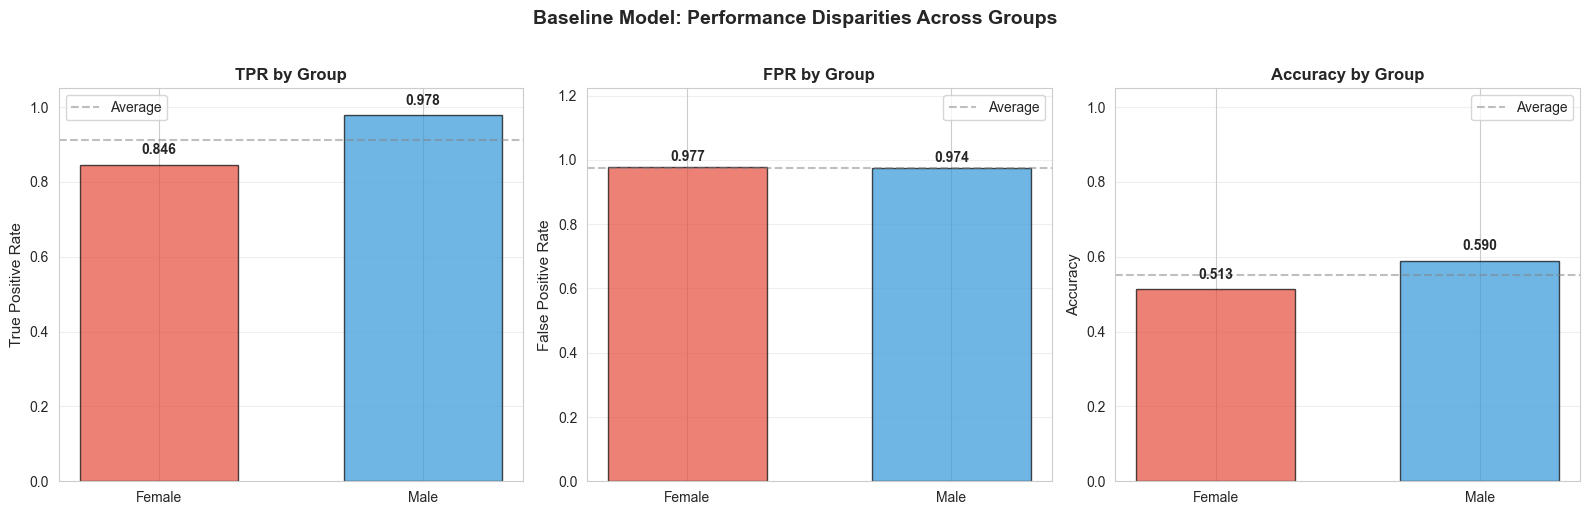

In [6]:
def plot_group_comparison(y_test, y_pred, protected_attr, title="Group Performance"):
    """Plot performance metrics by demographic group."""
    from sklearn.metrics import confusion_matrix
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    groups = [0, 1]
    group_names = ['Female', 'Male']
    colors = ['#e74c3c', '#3498db']
    
    metrics_data = {'Group': [], 'TPR': [], 'FPR': [], 'Accuracy': []}
    
    for group in groups:
        mask = protected_attr == group
        y_true_group = y_test[mask]
        y_pred_group = y_pred[mask]
        
        tn, fp, fn, tp = confusion_matrix(y_true_group, y_pred_group, labels=[0, 1]).ravel()
        
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        
        metrics_data['Group'].append(group_names[group])
        metrics_data['TPR'].append(tpr)
        metrics_data['FPR'].append(fpr)
        metrics_data['Accuracy'].append(accuracy)
    
    # Plot 1: TPR comparison
    axes[0].bar(group_names, metrics_data['TPR'], color=colors, alpha=0.7, edgecolor='black', width=0.6)
    axes[0].set_ylabel('True Positive Rate', fontsize=11)
    axes[0].set_title('TPR by Group', fontsize=12, fontweight='bold')
    axes[0].set_ylim(0, 1.05)
    axes[0].axhline(y=np.mean(metrics_data['TPR']), color='gray', linestyle='--', alpha=0.5, label='Average')
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    for i, v in enumerate(metrics_data['TPR']):
        axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Plot 2: FPR comparison
    axes[1].bar(group_names, metrics_data['FPR'], color=colors, alpha=0.7, edgecolor='black', width=0.6)
    axes[1].set_ylabel('False Positive Rate', fontsize=11)
    axes[1].set_title('FPR by Group', fontsize=12, fontweight='bold')
    axes[1].set_ylim(0, max(metrics_data['FPR']) * 1.2 + 0.05)
    axes[1].axhline(y=np.mean(metrics_data['FPR']), color='gray', linestyle='--', alpha=0.5, label='Average')
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)
    for i, v in enumerate(metrics_data['FPR']):
        axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Plot 3: Accuracy comparison
    axes[2].bar(group_names, metrics_data['Accuracy'], color=colors, alpha=0.7, edgecolor='black', width=0.6)
    axes[2].set_ylabel('Accuracy', fontsize=11)
    axes[2].set_title('Accuracy by Group', fontsize=12, fontweight='bold')
    axes[2].set_ylim(0, 1.05)
    axes[2].axhline(y=np.mean(metrics_data['Accuracy']), color='gray', linestyle='--', alpha=0.5, label='Average')
    axes[2].legend()
    axes[2].grid(axis='y', alpha=0.3)
    for i, v in enumerate(metrics_data['Accuracy']):
        axes[2].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# Visualize baseline
plot_group_comparison(y_test, y_pred_biased, protected_test, 
                     title="Baseline Model: Performance Disparities Across Groups")

### Visualize Fairness Metrics

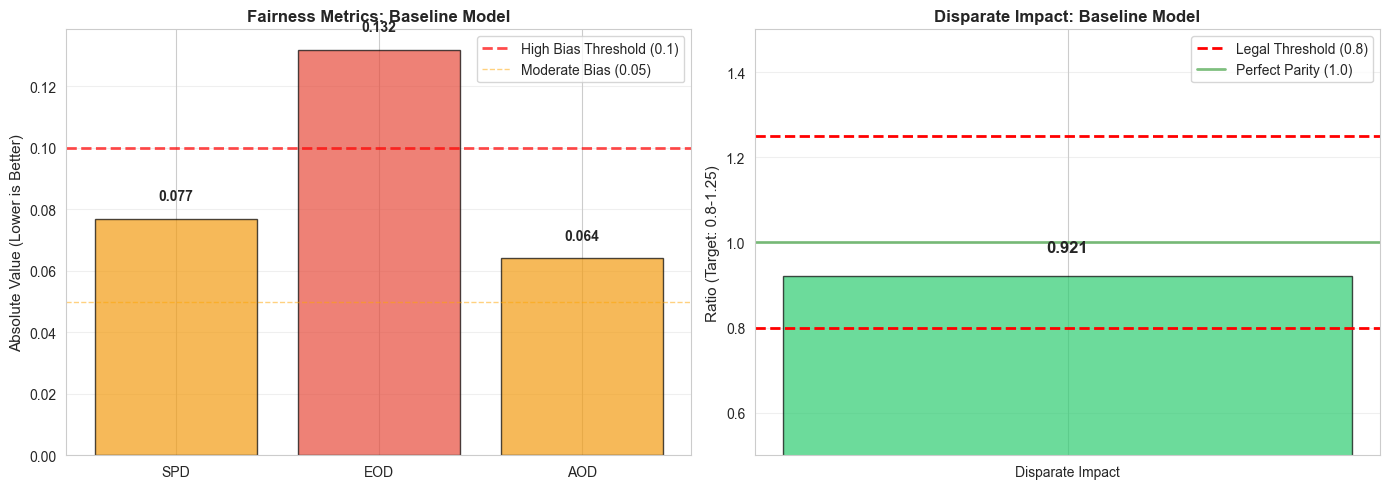


INTERPRETATION
⚠️  HIGH BIAS DETECTED: Equal Opportunity Difference exceeds 0.1
   Female group has 13.2% lower TPR than Male group
✓ Passes 80% rule for Disparate Impact


In [7]:
# Plot fairness metrics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: SPD, EOD, AOD (absolute values)
metrics_names = ['SPD', 'EOD', 'AOD']
metrics_values = [
    abs(baseline_fairness['spd']),
    abs(baseline_fairness['eod']),
    abs(baseline_fairness['aod'])
]

colors = ['#e74c3c' if v > 0.1 else '#f39c12' if v > 0.05 else '#2ecc71' for v in metrics_values]
bars1 = axes[0].bar(metrics_names, metrics_values, color=colors, alpha=0.7, edgecolor='black')
axes[0].axhline(y=0.1, color='red', linestyle='--', linewidth=2, alpha=0.7, label='High Bias Threshold (0.1)')
axes[0].axhline(y=0.05, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='Moderate Bias (0.05)')
axes[0].set_ylabel('Absolute Value (Lower is Better)', fontsize=11)
axes[0].set_title('Fairness Metrics: Baseline Model', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

for i, v in enumerate(metrics_values):
    axes[0].text(i, v + 0.005, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Disparate Impact
di_value = baseline_fairness['di']
di_color = '#2ecc71' if 0.8 <= di_value <= 1.25 else '#e74c3c'
axes[1].bar(['Disparate Impact'], [di_value], color=di_color, alpha=0.7, edgecolor='black', width=0.4)
axes[1].axhline(y=0.8, color='red', linestyle='--', linewidth=2, label='Legal Threshold (0.8)')
axes[1].axhline(y=1.0, color='green', linestyle='-', linewidth=2, alpha=0.5, label='Perfect Parity (1.0)')
axes[1].axhline(y=1.25, color='red', linestyle='--', linewidth=2)
axes[1].set_ylabel('Ratio (Target: 0.8-1.25)', fontsize=11)
axes[1].set_title('Disparate Impact: Baseline Model', fontsize=12, fontweight='bold')
axes[1].set_ylim(0.5, 1.5)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)
axes[1].text(0, di_value + 0.05, f'{di_value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

# Interpretation
print("\n" + "="*70)
print("INTERPRETATION")
print("="*70)
if abs(baseline_fairness['eod']) > 0.1:
    print("⚠️  HIGH BIAS DETECTED: Equal Opportunity Difference exceeds 0.1")
    print(f"   Female group has {abs(baseline_fairness['eod'])*100:.1f}% lower TPR than Male group")
else:
    print("✓ Low bias in Equal Opportunity")

if baseline_fairness['di'] < 0.8:
    print("⚠️  FAILS 80% RULE: Disparate Impact below legal threshold")
elif baseline_fairness['di'] > 1.25:
    print("⚠️  REVERSE DISCRIMINATION: Disparate Impact exceeds 1.25")
else:
    print("✓ Passes 80% rule for Disparate Impact")

print("="*70)

## 5. Bias Mitigation: Pre-processing (Fair Reweighting)

Apply class reweighting to balance demographic groups during training.

In [8]:
# Prepare training data with protected attribute
X_train_df = pd.DataFrame(X_train, columns=feature_cols)
X_train_df['protected_attr'] = protected_train

# Compute fair weights
reweighter = FairReweighting(protected_attr_name='protected_attr')
sample_weights = reweighter.fit_transform(X_train_df, y_train)

print("Fair Reweighting Applied:")
print(f"  Female group average weight: {np.mean(sample_weights[protected_train == 0]):.3f}")
print(f"  Male group average weight: {np.mean(sample_weights[protected_train == 1]):.3f}")

# Train model with fair weights
reweighted_model = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED)
reweighted_model.fit(X_train, y_train, sample_weight=sample_weights)

# Predict on test set
y_pred_reweighted = reweighted_model.predict(X_test)
y_score_reweighted = reweighted_model.predict_proba(X_test)[:, 1]

# Performance
print("\n" + "="*70)
print("REWEIGHTED MODEL PERFORMANCE")
print("="*70)
print(f"Accuracy: {accuracy_score(y_test, y_pred_reweighted):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_reweighted):.4f}")

# Fairness evaluation
fm_reweighted = FairnessMetrics(y_test, y_pred_reweighted, protected_test)
print("\n" + fm_reweighted.fairness_report())

Fair Reweighting Applied:
  Female group average weight: 1.024
  Male group average weight: 0.977

REWEIGHTED MODEL PERFORMANCE
Accuracy: 0.5011
F1-Score: 0.5328

FAIRNESS EVALUATION REPORT

GROUP STATISTICS
----------------------------------------------------------------------

UNPRIVILEGED GROUP (n=437):
  True Positive Rate (TPR):  0.5462
  False Positive Rate (FPR): 0.4463
  Positive Prediction Rate:  0.5057
  Confusion Matrix: TP=142, FP=79, TN=98, FN=118

PRIVILEGED GROUP (n=463):
  True Positive Rate (TPR):  0.4161
  False Positive Rate (FPR): 0.4868
  Positive Prediction Rate:  0.4449
  Confusion Matrix: TP=114, FP=92, TN=97, FN=160


FAIRNESS METRICS
----------------------------------------------------------------------
Statistical Parity Difference (SPD): +0.0608
  → Ideal: 0.0 | Current: ✓ Fair

Equal Opportunity Difference (EOD):  +0.1301
  → Ideal: 0.0 | Current: ✗ Biased

Average Odds Difference (AOD):       +0.0448
  → Ideal: 0.0 | Current: ✓ Fair

Disparate Impact (DI):

## 6. Bias Mitigation: Post-processing (Threshold Calibration)

Adjust decision thresholds per demographic group to equalize true positive rates.

In [9]:
# Apply threshold calibration to baseline model
calibrator = ThresholdCalibrator(target_metric='equal_opportunity')
calibrator.fit(y_test, y_score_baseline, protected_test)

print("Calibrated Thresholds:")
for group, threshold in calibrator.thresholds_.items():
    group_name = "Female" if group == 0 else "Male"
    print(f"  {group_name} (Group {group}): {threshold:.4f}")

# Get calibrated predictions
y_pred_calibrated = calibrator.predict(y_score_baseline, protected_test)

# Performance
print("\n" + "="*70)
print("CALIBRATED MODEL PERFORMANCE")
print("="*70)
print(f"Accuracy: {accuracy_score(y_test, y_pred_calibrated):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_calibrated):.4f}")

# Fairness evaluation
fm_calibrated = FairnessMetrics(y_test, y_pred_calibrated, protected_test)
print("\n" + fm_calibrated.fairness_report())

Calibrated Thresholds:
  Female (Group 0): 0.5023
  Male (Group 1): 0.4903

CALIBRATED MODEL PERFORMANCE
Accuracy: 0.5956
F1-Score: 0.7437

FAIRNESS EVALUATION REPORT

GROUP STATISTICS
----------------------------------------------------------------------

UNPRIVILEGED GROUP (n=437):
  True Positive Rate (TPR):  0.9923
  False Positive Rate (FPR): 0.9718
  Positive Prediction Rate:  0.9840
  Confusion Matrix: TP=258, FP=172, TN=5, FN=2

PRIVILEGED GROUP (n=463):
  True Positive Rate (TPR):  0.9854
  False Positive Rate (FPR): 0.9841
  Positive Prediction Rate:  0.9849
  Confusion Matrix: TP=270, FP=186, TN=3, FN=4


FAIRNESS METRICS
----------------------------------------------------------------------
Statistical Parity Difference (SPD): -0.0009
  → Ideal: 0.0 | Current: ✓ Fair

Equal Opportunity Difference (EOD):  +0.0069
  → Ideal: 0.0 | Current: ✓ Fair

Average Odds Difference (AOD):       -0.0027
  → Ideal: 0.0 | Current: ✓ Fair

Disparate Impact (DI):               0.9991
  → Leg

## 7. Compare All Approaches

Let's compare baseline, reweighted, and calibrated models side-by-side.

In [10]:
# Create comparison dataframe
results = []

# Baseline
baseline_metrics = fm_baseline.compute_all_metrics()
results.append({
    'Method': 'Baseline (Biased)',
    'Accuracy': accuracy_score(y_test, y_pred_biased),
    'F1-Score': f1_score(y_test, y_pred_biased),
    'SPD': baseline_metrics['spd'],
    'EOD': baseline_metrics['eod'],
    'AOD': baseline_metrics['aod'],
    'DI': baseline_metrics['di']
})

# Reweighted
reweighted_metrics = fm_reweighted.compute_all_metrics()
results.append({
    'Method': 'Fair Reweighting',
    'Accuracy': accuracy_score(y_test, y_pred_reweighted),
    'F1-Score': f1_score(y_test, y_pred_reweighted),
    'SPD': reweighted_metrics['spd'],
    'EOD': reweighted_metrics['eod'],
    'AOD': reweighted_metrics['aod'],
    'DI': reweighted_metrics['di']
})

# Calibrated
calibrated_metrics = fm_calibrated.compute_all_metrics()
results.append({
    'Method': 'Threshold Calibration',
    'Accuracy': accuracy_score(y_test, y_pred_calibrated),
    'F1-Score': f1_score(y_test, y_pred_calibrated),
    'SPD': calibrated_metrics['spd'],
    'EOD': calibrated_metrics['eod'],
    'AOD': calibrated_metrics['aod'],
    'DI': calibrated_metrics['di']
})

df_results = pd.DataFrame(results)

# Display table
print("\n" + "="*90)
print("COMPARISON: BASELINE VS. MITIGATION TECHNIQUES")
print("="*90)
print(df_results.to_string(index=False))
print("="*90)

# Calculate improvements
print("\nIMPROVEMENTS OVER BASELINE:")
print("-"*90)
for i in range(1, len(df_results)):
    method = df_results.iloc[i]['Method']
    eod_baseline = abs(df_results.iloc[0]['EOD'])
    eod_mitigated = abs(df_results.iloc[i]['EOD'])
    eod_reduction = ((eod_baseline - eod_mitigated) / eod_baseline * 100) if eod_baseline > 0 else 0
    
    acc_change = (df_results.iloc[i]['Accuracy'] - df_results.iloc[0]['Accuracy']) * 100
    
    print(f"\n{method}:")
    print(f"  EOD Reduction: {eod_reduction:.1f}%")
    print(f"  Accuracy Change: {acc_change:+.2f}%")
    print(f"  Passes 80% Rule: {'✓' if 0.8 <= df_results.iloc[i]['DI'] <= 1.25 else '✗'}")


COMPARISON: BASELINE VS. MITIGATION TECHNIQUES
               Method  Accuracy  F1-Score       SPD       EOD       AOD       DI
    Baseline (Biased)  0.552222  0.707759 -0.076928 -0.131948 -0.064046 0.921199
     Fair Reweighting  0.501111  0.532778  0.060796  0.130095  0.044825 1.136644
Threshold Calibration  0.595556  0.743662 -0.000900  0.006906 -0.002735 0.999087

IMPROVEMENTS OVER BASELINE:
------------------------------------------------------------------------------------------

Fair Reweighting:
  EOD Reduction: 1.4%
  Accuracy Change: -5.11%
  Passes 80% Rule: ✓

Threshold Calibration:
  EOD Reduction: 94.8%
  Accuracy Change: +4.33%
  Passes 80% Rule: ✓


### Visualize Comparison

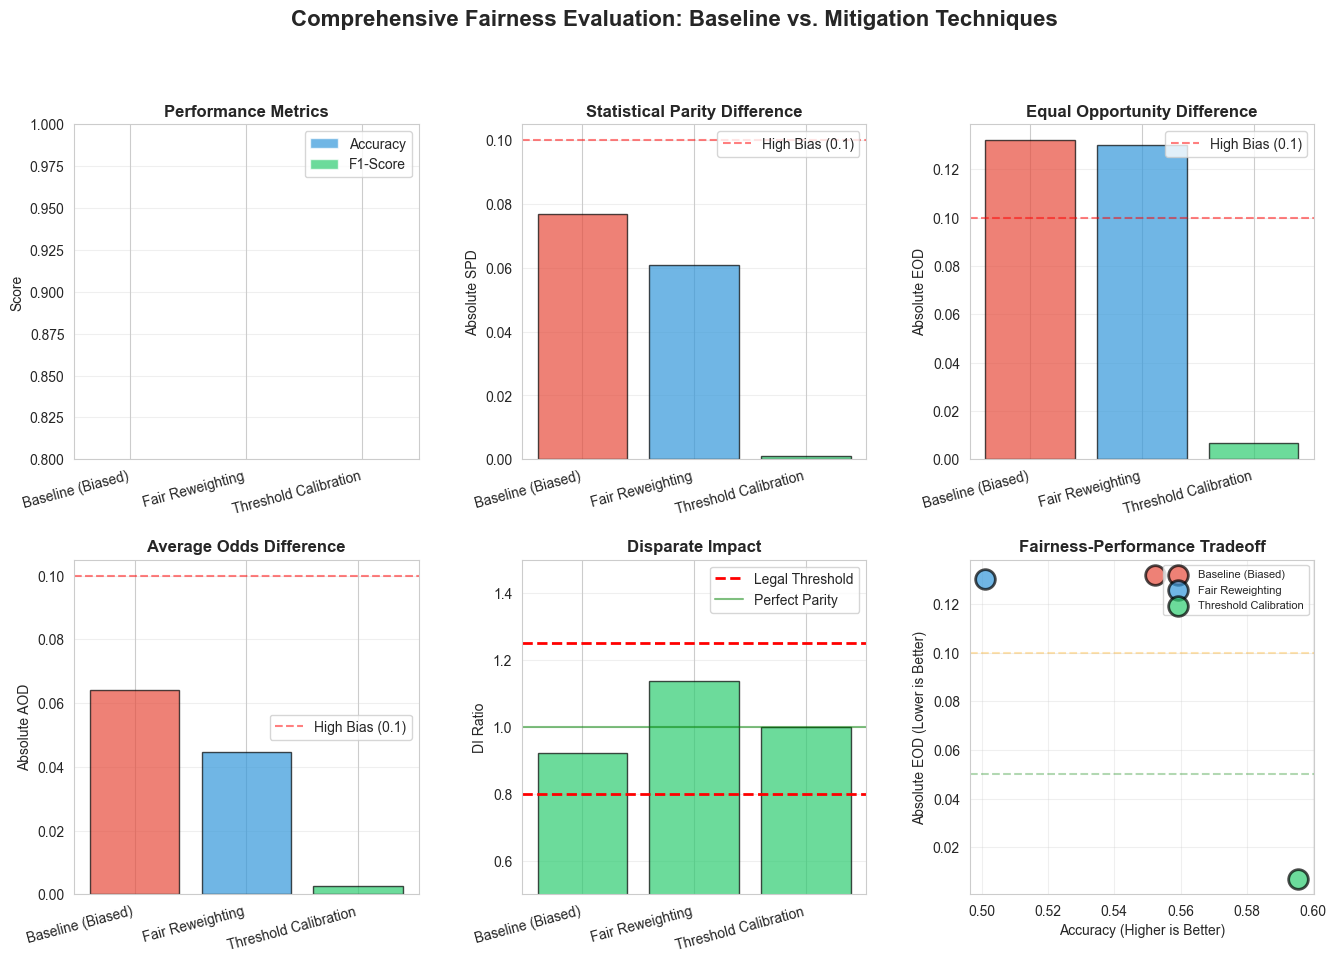

In [11]:
# Create comprehensive comparison visualization
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

methods = df_results['Method'].values
colors_methods = ['#e74c3c', '#3498db', '#2ecc71']

# Plot 1: Performance Metrics
ax1 = fig.add_subplot(gs[0, 0])
x = np.arange(len(methods))
width = 0.35
ax1.bar(x - width/2, df_results['Accuracy'], width, label='Accuracy', color='#3498db', alpha=0.7)
ax1.bar(x + width/2, df_results['F1-Score'], width, label='F1-Score', color='#2ecc71', alpha=0.7)
ax1.set_ylabel('Score')
ax1.set_title('Performance Metrics', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(methods, rotation=15, ha='right')
ax1.legend()
ax1.set_ylim(0.8, 1.0)
ax1.grid(axis='y', alpha=0.3)

# Plot 2: SPD
ax2 = fig.add_subplot(gs[0, 1])
bars = ax2.bar(methods, np.abs(df_results['SPD']), color=colors_methods, alpha=0.7, edgecolor='black')
ax2.axhline(y=0.1, color='red', linestyle='--', alpha=0.5, label='High Bias (0.1)')
ax2.set_ylabel('Absolute SPD')
ax2.set_title('Statistical Parity Difference', fontweight='bold')
ax2.set_xticklabels(methods, rotation=15, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Plot 3: EOD
ax3 = fig.add_subplot(gs[0, 2])
bars = ax3.bar(methods, np.abs(df_results['EOD']), color=colors_methods, alpha=0.7, edgecolor='black')
ax3.axhline(y=0.1, color='red', linestyle='--', alpha=0.5, label='High Bias (0.1)')
ax3.set_ylabel('Absolute EOD')
ax3.set_title('Equal Opportunity Difference', fontweight='bold')
ax3.set_xticklabels(methods, rotation=15, ha='right')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Plot 4: AOD
ax4 = fig.add_subplot(gs[1, 0])
bars = ax4.bar(methods, np.abs(df_results['AOD']), color=colors_methods, alpha=0.7, edgecolor='black')
ax4.axhline(y=0.1, color='red', linestyle='--', alpha=0.5, label='High Bias (0.1)')
ax4.set_ylabel('Absolute AOD')
ax4.set_title('Average Odds Difference', fontweight='bold')
ax4.set_xticklabels(methods, rotation=15, ha='right')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# Plot 5: Disparate Impact
ax5 = fig.add_subplot(gs[1, 1])
di_colors = ['#e74c3c' if v < 0.8 or v > 1.25 else '#2ecc71' for v in df_results['DI']]
bars = ax5.bar(methods, df_results['DI'], color=di_colors, alpha=0.7, edgecolor='black')
ax5.axhline(y=0.8, color='red', linestyle='--', linewidth=2, label='Legal Threshold')
ax5.axhline(y=1.0, color='green', linestyle='-', linewidth=1.5, alpha=0.5, label='Perfect Parity')
ax5.axhline(y=1.25, color='red', linestyle='--', linewidth=2)
ax5.set_ylabel('DI Ratio')
ax5.set_title('Disparate Impact', fontweight='bold')
ax5.set_xticklabels(methods, rotation=15, ha='right')
ax5.set_ylim(0.5, 1.5)
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

# Plot 6: Fairness-Performance Tradeoff
ax6 = fig.add_subplot(gs[1, 2])
for i, method in enumerate(methods):
    ax6.scatter(df_results.iloc[i]['Accuracy'],
               abs(df_results.iloc[i]['EOD']),
               s=200, color=colors_methods[i], alpha=0.7,
               edgecolor='black', linewidth=2, label=method)
ax6.set_xlabel('Accuracy (Higher is Better)')
ax6.set_ylabel('Absolute EOD (Lower is Better)')
ax6.set_title('Fairness-Performance Tradeoff', fontweight='bold')
ax6.legend(loc='upper right', fontsize=8)
ax6.grid(alpha=0.3)
ax6.axhline(y=0.05, color='green', linestyle='--', alpha=0.3, label='Low Bias')
ax6.axhline(y=0.1, color='orange', linestyle='--', alpha=0.3, label='Moderate Bias')

plt.suptitle('Comprehensive Fairness Evaluation: Baseline vs. Mitigation Techniques',
             fontsize=16, fontweight='bold', y=0.995)
plt.show()

### Group-Level Performance Comparison

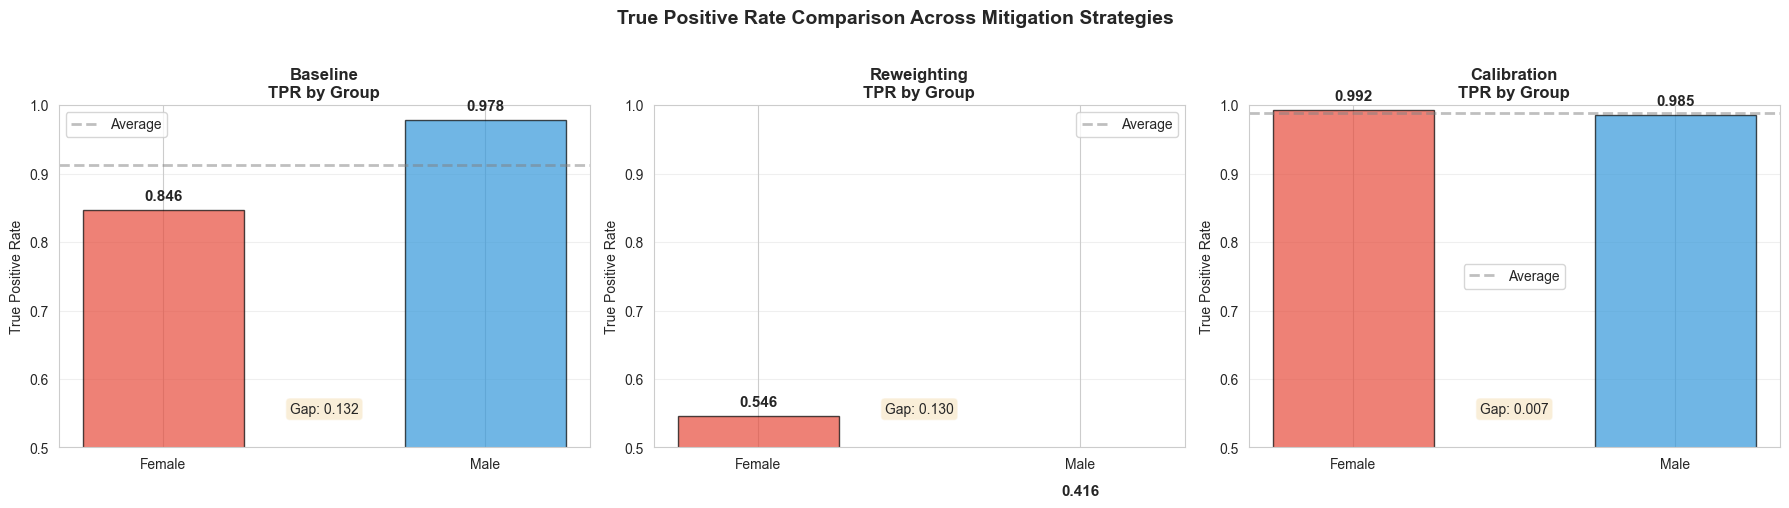

In [12]:
# Compare group performance across methods
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

predictions = [
    ('Baseline', y_pred_biased),
    ('Reweighting', y_pred_reweighted),
    ('Calibration', y_pred_calibrated)
]

for idx, (title, y_pred) in enumerate(predictions):
    # Compute TPR for each group
    tpr_female = np.sum((y_test[protected_test == 0] == 1) & (y_pred[protected_test == 0] == 1)) / np.sum(y_test[protected_test == 0] == 1)
    tpr_male = np.sum((y_test[protected_test == 1] == 1) & (y_pred[protected_test == 1] == 1)) / np.sum(y_test[protected_test == 1] == 1)
    
    groups = ['Female', 'Male']
    tprs = [tpr_female, tpr_male]
    colors = ['#e74c3c', '#3498db']
    
    bars = axes[idx].bar(groups, tprs, color=colors, alpha=0.7, edgecolor='black', width=0.5)
    axes[idx].set_ylabel('True Positive Rate')
    axes[idx].set_title(f'{title}\nTPR by Group', fontweight='bold')
    axes[idx].set_ylim(0.5, 1.0)
    axes[idx].axhline(y=np.mean(tprs), color='gray', linestyle='--', linewidth=2, alpha=0.5, label='Average')
    axes[idx].legend()
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(tprs):
        axes[idx].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    # Add gap annotation
    gap = abs(tpr_female - tpr_male)
    axes[idx].text(0.5, 0.55, f'Gap: {gap:.3f}', ha='center', fontsize=10,
                  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('True Positive Rate Comparison Across Mitigation Strategies',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 9. Save Results

In [15]:
# Save comparison table
results_dir = Path('../results')
results_dir.mkdir(exist_ok=True)

df_results.to_csv(results_dir / 'fairness_comparison.csv', index=False)
print(f"✓ Results saved to: {results_dir / 'fairness_comparison.csv'}")

# Helper function to convert numpy types to native Python types
def convert_to_native_types(obj):
    """Recursively convert numpy types to native Python types for JSON serialization."""
    if isinstance(obj, dict):
        return {key: convert_to_native_types(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_native_types(item) for item in obj]
    elif isinstance(obj, (np.integer, np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return obj

# Save detailed metrics
detailed_metrics = {
    'baseline': {
        'fairness': baseline_metrics,
        'group_stats': fm_baseline.get_group_statistics()
    },
    'reweighted': {
        'fairness': reweighted_metrics,
        'group_stats': fm_reweighted.get_group_statistics()
    },
    'calibrated': {
        'fairness': calibrated_metrics,
        'group_stats': fm_calibrated.get_group_statistics()
    }
}

# Convert numpy types to native Python types
detailed_metrics = convert_to_native_types(detailed_metrics)

import json
with open(results_dir / 'detailed_fairness_metrics.json', 'w') as f:
    json.dump(detailed_metrics, f, indent=2)
print(f"✓ Detailed metrics saved to: {results_dir / 'detailed_fairness_metrics.json'}")

print("\n" + "="*70)
print("ANALYSIS COMPLETE")
print("="*70)

✓ Results saved to: ..\results\fairness_comparison.csv
✓ Detailed metrics saved to: ..\results\detailed_fairness_metrics.json

ANALYSIS COMPLETE
